# SVM for NLP in Python

Problem statement: build a Machine Learning model that can identify whether a URL is malicious or not.

In [47]:
import pandas as pd

total_data = pd.read_csv("../data/raw/url_spam.csv")
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


## URL preprocessing

In [48]:
# checking whether dataset balanced 
print(total_data.shape)
print(f"Spam: {len(total_data.loc[total_data.is_spam == True])}")
print(f"No spam: {len(total_data.loc[total_data.is_spam == False])}")

(2999, 2)
Spam: 696
No spam: 2303


In [49]:
#remove duplicates
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace = False, drop = True)
total_data.shape

(2369, 2)

In [50]:
import re
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def split_and_lemmatize_url(url):
    # Split on delimiters
    raw_tokens = re.split(r'[\/\.\-_\?\=&]', url)
    raw_tokens = [t.lower() for t in raw_tokens if t]

    # Convert to spaCy doc (one fake sentence)
    doc = nlp(" ".join(raw_tokens))
    
    # Lemmatize each token
    lemmas = [token.lemma_ for token in doc if token.is_alpha]
    
    return lemmas


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=split_and_lemmatize_url, token_pattern=None)


In [52]:

X = vectorizer.fit_transform(total_data['url'])



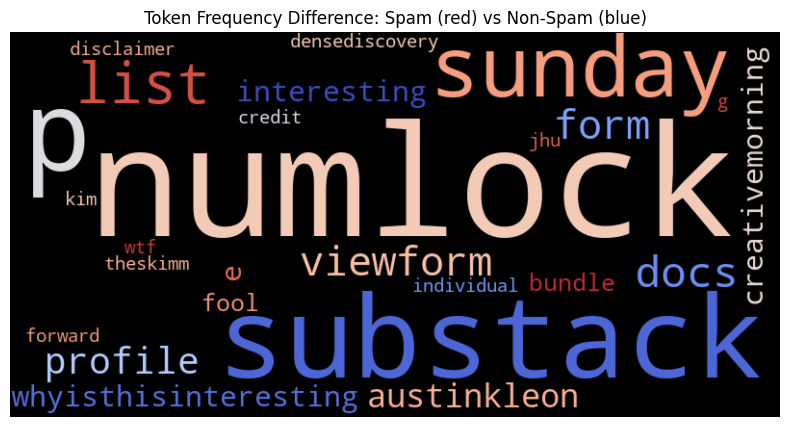

In [53]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create token lists per class
spam_tokens = []
non_spam_tokens = []

for url, label in zip(total_data['url'], total_data['is_spam']):
    tokens = split_and_lemmatize_url(url)
    if label == 1:
        spam_tokens.extend(tokens)
    else:
        non_spam_tokens.extend(tokens)

# Frequency dictionaries
spam_freq = Counter(spam_tokens)
non_spam_freq = Counter(non_spam_tokens)

# Make sure only common keys for color contrast
common_tokens = set(spam_freq.keys()) & set(non_spam_freq.keys())

# Combine: spam freq positive, non-spam negative
combined_freq = {token: spam_freq[token] - non_spam_freq[token] for token in common_tokens}

# Create a word cloud where color intensity shows direction of spam association
wc = WordCloud(width=800, height=400, colormap='coolwarm')
wc.generate_from_frequencies(combined_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Token Frequency Difference: Spam (red) vs Non-Spam (blue)")
plt.show()


## Model training with SVM (Support Vector Machine)

In [54]:
from sklearn.model_selection import train_test_split

y = total_data['is_spam']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y) # stratify=y to balance classes in both sets

In [55]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train, y_train)


LinearSVC()

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[420   5]
 [ 26  23]]
              precision    recall  f1-score   support

       False       0.94      0.99      0.96       425
        True       0.82      0.47      0.60        49

    accuracy                           0.93       474
   macro avg       0.88      0.73      0.78       474
weighted avg       0.93      0.93      0.93       474



## Hyperparameter Optimization

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC


param_grid = {'C': [0.01, 0.1, 1, 10, 100]}


grid = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring='precision', n_jobs=-1)
grid.fit(X_train, y_train)


print("Best parameter:", grid.best_params_)
print("Best cross-validated precision:", grid.best_score_)


best_model = grid.best_estimator_
y_pred_optimized = best_model.predict(X_test)


print(classification_report(y_test, y_pred_optimized))


Best parameter: {'C': 0.1}
Best cross-validated precision: 0.9382783882783883
              precision    recall  f1-score   support

       False       0.92      1.00      0.96       425
        True       1.00      0.29      0.44        49

    accuracy                           0.93       474
   macro avg       0.96      0.64      0.70       474
weighted avg       0.93      0.93      0.91       474



## Saving the model

In [58]:
from pickle import dump

dump(best_model, open("svm_classifier_linear_42.sav", "wb"))